In [70]:
import sys
import os

from datetime import datetime

import polars as pl
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

src_path = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
sys.path.append(src_path)
from utils import lift_metric_plot

In [26]:
pl_data = pl.read_csv("/Users/kurmangazykarabekov/Desktop/собесы/12Go Asia/data.csv")

# Prepare data

**Conver date from object to datetime**

In [27]:
pl_data = (
    pl_data.with_columns(
        pl.col("createdon")
        .str.strptime(
            pl.Datetime,
            format="%Y-%m-%d %H:%M:%S%z",
        )
        .cast(pl.Datetime("us", time_zone="UTC"))
    )
    .with_columns(
        pl.col("date_of_birth")
        .str.strptime(
            pl.Datetime,
            format="%Y-%m-%d",
        )
        .cast(pl.Datetime("us", time_zone="UTC"))
    )
    .with_columns(
        pl.col("godate")
        .str.strptime(
            pl.Datetime,
            format="%Y-%m-%d %H:%M:%S%z",
        )
        .cast(pl.Datetime("us", time_zone="UTC"))
    )
    .with_columns(
        pl.col("paidon")
        .str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S.%f%z", strict=False)
        .cast(pl.Datetime("us", time_zone="UTC"))
    )
)

/var/folders/l9/p8dmtkcx40g8jtfzctxzg4km0000gn/T/ipykernel_76841/1105408612.py:28: ChronoFormatWarning: Detected the pattern `.%f` in the chrono format string. This pattern should not be used to parse values after a decimal point. Use `%.f` instead. See the full specification: https://docs.rs/chrono/latest/chrono/format/strftime
  .str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S.%f%z", strict=False)


In [ ]:
# pl_data = pl_data.with_columns(
#     [
#         pl.col("createdon").cast(pl.Datetime("us", time_zone="UTC")),
#         pl.col("paidon").cast(pl.Datetime("us", time_zone="UTC")),
#         pl.col("godate").cast(pl.Datetime("us", time_zone="UTC")),
#         pl.col("date_of_birth").cast(pl.Datetime("us", time_zone="UTC")),
#     ]
# )

**Let's sort all the events so that we can further split the data by booking creation**

In [28]:
pl_data = pl_data.sort("createdon", descending=False)

**Prepare null values**

In [29]:
pl_data = pl_data.with_columns(
    pl.col("channel").fill_null("unknown"),
    pl.col("cust_name").fill_null("unknown"),
    pl.col("nationality").fill_null("unknown"),
    pl.col("payer_country").fill_null("unknown"),
    pl.col("proxy").fill_null(0.0),
    pl.col("tor").fill_null(0.0),
    pl.col("vpn").fill_null(0.0),
    pl.col("recent_abuse").fill_null(0.0),
)

In [30]:
print(f"Min date of booking {pl_data['createdon'].min()}")
print(f"Max date of booking {pl_data['createdon'].max()}")

Min date of booking 2021-04-30 17:21:17+00:00
Max date of booking 2023-11-30 16:59:52+00:00


# Features engineering

In [ ]:
# 1. Features based on email_score and other score
pl_data = pl_data.with_columns(
    [
        (pl.col("email_score") * pl.col("passenger_score")).alias("score_interaction"),
        ((pl.col("email_score") + pl.col("passenger_score")) / 2).alias(
            "avg_risk_score"
        ),
        (pl.max_horizontal(["email_score", "passenger_score"])).alias("max_risk_score"),
        # Deviation from the average score
        (pl.col("email_score") - pl.col("email_score").mean()).alias(
            "email_score_deviation"
        ),
    ]
)

In [ ]:
# 2. Price-based features (net price_thb)
pl_data = pl_data.with_columns(
    [  # Price per seat
        (pl.col("netprice_thb") / pl.col("seats")).alias("price_per_seat"),
        # Price deviation from the average for this type of transport
        (
            pl.col("netprice_thb") - pl.col("netprice_thb").mean().over("vehclass_id")
        ).alias("price_deviation"),
        # Percentage deviation of the price
        (
            (pl.col("netprice_thb") - pl.col("netprice_thb").mean().over("vehclass_id"))
            / pl.col("netprice_thb").mean().over("vehclass_id")
            * 100
        ).alias("price_deviation_percent"),
    ]
)

In [ ]:
# 3. Security Features
pl_data = pl_data.with_columns(
    [
        (
            pl.col("proxy") + pl.col("vpn") + pl.col("tor") + pl.col("recent_abuse")
        ).alias("security_flags_sum"),
        (
            (pl.col("proxy") + pl.col("vpn") + pl.col("tor") + pl.col("recent_abuse"))
            > 0
        ).alias("has_security_flag"),
    ]
)

In [ ]:
# 4. Features based on payment attempts (p_attempts)
pl_data = pl_data.with_columns(
    [
        (pl.col("p_attempts") > 2).alias("multiple_attempts"),
        (pl.col("p_attempts").log1p()).alias("log_attempts"),
    ]
)

In [ ]:
# 5. Channel aggregations
channel_stats = pl_data.group_by("channel").agg(
    [
        (pl.col("netprice_thb").mean()).alias("channel_avg_price"),
        (pl.col("seats").mean()).alias("channel_avg_seats"),
        (pl.col("email_score").mean()).alias("channel_avg_score"),
    ]
)

pl_data = pl_data.join(channel_stats, on="channel")

In [ ]:
# 6. Combined features for the type of transport (vehclass_id)
pl_data = pl_data.with_columns(
    [  # Average price per seat for this type of transport
        (
            pl.col("netprice_thb").mean().over("vehclass_id")
            / pl.col("seats").mean().over("vehclass_id")
        ).alias("vehclass_avg_price_per_seat"),
        # Deviation from the average price per seat
        (
            (pl.col("netprice_thb") / pl.col("seats"))
            - (
                pl.col("netprice_thb").mean().over("vehclass_id")
                / pl.col("seats").mean().over("vehclass_id")
            )
        ).alias("price_per_seat_deviation"),
    ]
)

In [ ]:
# 7. Interactions between important features
pl_data = pl_data.with_columns(
    [
        (pl.col("email_score") * pl.col("netprice_thb")).alias(
            "score_price_interaction"
        ),
        (pl.col("email_score") * pl.col("security_flags_sum")).alias(
            "score_security_interaction"
        ),
    ]
)

In [ ]:
# 8. Features for the insurance flag (insurance_flg)
pl_data = pl_data.with_columns(
    [  # Price-to-average ratio with/without insurance
        (
            pl.col("netprice_thb") / pl.col("netprice_thb").mean().over("insurance_flg")
        ).alias("price_to_insurance_avg"),
    ]
)

In [ ]:
# 9. Creating time-related features
pl_data = pl_data.with_columns(
    [  # The difference between the creation and payment time (in hours)
        ((pl.col("paidon") - pl.col("createdon")).dt.total_seconds() / 3600).alias(
            "hours_to_pay"
        ),
        # The difference between the payment and the trip (in days)
        ((pl.col("godate") - pl.col("paidon")).dt.total_seconds() / (3600 * 24)).alias(
            "days_to_trip"
        ),
        # Difference between creation and trip (in days)
        (
            (pl.col("godate") - pl.col("createdon")).dt.total_seconds() / (3600 * 24)
        ).alias("days_from_creation_to_trip"),
    ]
)

In [ ]:
# 10. We add more complex features over time
pl_data = pl_data.with_columns(
    [
        (pl.col("hours_to_pay") < 1 / 60).alias("instant_payment"),
        (pl.col("hours_to_pay") < 5 / 60).alias("suspicious_fast_payment"),
        (pl.col("hours_to_pay") > 24).alias("long_payment"),
        (pl.col("days_to_trip") < 7).alias("near_trip"),
        (pl.col("days_to_trip") > 90).alias("far_future_trip"),
    ]
)

In [ ]:
# 11. Basic age features
pl_data = pl_data.with_columns(
    [
        ((pl.col("createdon") - pl.col("date_of_birth")).dt.days() / 365.25).alias(
            "age"
        ),
        ((pl.col("godate") - pl.col("date_of_birth")).dt.days() / 365.25).alias(
            "age_at_trip"
        ),
    ]
)

/var/folders/l9/p8dmtkcx40g8jtfzctxzg4km0000gn/T/ipykernel_76841/315636817.py:3: DeprecationWarning: `days` is deprecated. It has been renamed to `total_days`.
  ((pl.col("createdon") - pl.col("date_of_birth")).dt.days() / 365.25).alias(
/var/folders/l9/p8dmtkcx40g8jtfzctxzg4km0000gn/T/ipykernel_76841/315636817.py:6: DeprecationWarning: `days` is deprecated. It has been renamed to `total_days`.
  ((pl.col("godate") - pl.col("date_of_birth")).dt.days() / 365.25).alias(


In [23]:
pl_data.head(5)

bid,channel,createdon,cust_name,date_of_birth,email,email_domain_score,email_score,godate,insurance_flg,ip,isFraud,nationality,netprice_thb,p_attempts,paidon,passenger_passport_score,passenger_score,payer_country,payer_name,proxy,recent_abuse,role_id,seats,tor,useragent,usr_name,vehclass_id,vpn,score_interaction,avg_risk_score,max_risk_score,email_score_deviation,price_per_seat,price_deviation,price_deviation_percent,security_flags_sum,has_security_flag,multiple_attempts,log_attempts,channel_avg_price,channel_avg_seats,channel_avg_score,vehclass_avg_price_per_seat,price_per_seat_deviation,score_price_interaction,score_security_interaction,price_to_insurance_avg,hours_to_pay,days_to_trip,days_from_creation_to_trip,instant_payment,suspicious_fast_payment,long_payment,near_trip,far_future_trip
i64,str,"datetime[μs, UTC]",str,datetime[μs],str,f64,f64,"datetime[μs, UTC]",i64,str,i64,str,f64,i64,"datetime[ns, UTC]",f64,f64,str,str,f64,f64,str,i64,f64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,bool,bool,bool,bool
6524445,"""affiliate""",2021-04-30 17:21:17 UTC,"""Tiffany Stephe…",1999-07-04 00:00:00,"""ryanbrianna@ou…",0.0,10.0,2021-07-01 00:30:00 UTC,0,"""213.89.6.2""",0,"""SE""",115.0,0,2021-06-29 09:57:12.000177348 UTC,0.0,0.0,"""SE""","""Tiffany Stephe…",0.0,0.0,"""user""",1,0.0,"""Phone,sv,SEK""","""Tiffany Stephe…","""van""",0.0,0.0,5.0,10.0,6.658495,115.0,-258.350472,-69.197843,0.0,false,false,0.0,732.835344,1.834371,3.429085,205.150919,-90.150919,1150.0,0.0,0.160478,1432.598611,1.6061,61.29772,false,false,true,true,false
5800338,"""affiliate""",2021-04-30 17:30:19 UTC,"""Amanda Cooper""",2002-06-07 00:00:00,"""dustin85@gmail…",0.0,10.0,2021-05-29 06:35:00 UTC,1,"""124.106.133.17…",0,"""TH""",985.180176,0,2021-05-24 20:58:15.000692073 UTC,0.0,0.0,"""NU""",null,0.0,0.0,"""user""",1,0.0,"""Phone,en,PHP""","""Amanda Cooper""","""avia""",0.0,0.0,5.0,10.0,6.658495,985.180176,-1790.30336,-64.504197,0.0,false,false,0.0,732.835344,1.834371,3.429085,1447.489083,-462.308907,9851.801758,0.0,1.195669,579.465556,4.400509,28.544919,false,false,true,true,false
7897646,"""direct""",2021-04-30 18:09:12 UTC,"""Victoria Corte…",null,"""johnny40@gmail…",0.0,2.0,2021-05-10 03:40:00 UTC,1,"""183.88.101.237…",0,"""TH""",2400.0,7,2021-05-05 11:40:55.000424451 UTC,0.0,0.0,"""CH""","""Victoria Corte…",0.0,0.0,"""user""",2,0.0,"""Phone,de,THB""","""Victoria Corte…","""avia""",0.0,0.0,1.0,2.0,-1.341505,1200.0,-375.483536,-13.528581,0.0,false,true,2.079442,864.710572,1.858332,3.382131,1447.489083,-247.489083,4800.0,0.0,2.912772,113.528611,4.666019,9.396389,false,false,true,true,false
7644834,"""direct""",2021-04-30 18:29:33 UTC,"""Victoria Corte…",1995-08-02 00:00:00,"""johnny40@gmail…",0.0,2.0,2021-05-10 05:00:00 UTC,1,"""183.88.101.237…",0,"""TH""",410.0,2,2021-05-05 21:07:31.000171406 UTC,0.0,0.0,"""CH""","""Victoria Corte…",0.0,0.0,"""user""",2,0.0,"""Phone,de,THB""","""Victoria Corte…","""bus""",0.0,0.0,1.0,2.0,-1.341505,205.0,-102.779204,-20.043559,0.0,false,false,1.098612,864.710572,1.858332,3.382131,298.047239,-93.047239,820.0,0.0,0.497599,122.632778,4.328102,9.4378125,false,false,true,true,false
7462960,"""unknown""",2021-04-30 18:36:36 UTC,"""Francisco Wagn…",1989-01-16 00:00:00,"""margaretcastan…",0.0,5.0,2021-05-02 03:33:00 UTC,1,"""183.171.184.14…",0,"""TH""",573.537903,0,2021-04-27 10:24:15.000421043 UTC,0.0,0.0,"""NU""",null,0.0,0.0,"""user""",1,0.0,"""Phone,en,MYR""","""Francisco Wagn…","""train""",0.0,0.0,2.5,5.0,1.658495,573.537903,-314.06581,-35.383562,0.0,false,false,0.0,715.642637,1.793547,2.579496,475.130668,98.407235,2867.689514,0.0,0.696077,-80.205556,4.714398,1.3725,true,true,false,true,false


# Split data by time

**To separate the data, we will use the date 2022-11-30 since the distribution of the target event will be approximately the same for training and testing**

In [43]:
date_split_utc = pl.datetime(2022, 11, 30, 0, 0, 0).cast(
    pl.Datetime("us", time_zone="UTC")
)

In [44]:
pl_data.filter(pl.col("createdon") < date_split_utc)[
    "isFraud"
].to_pandas().value_counts(normalize=True)

isFraud
0    0.997879
1    0.002121
Name: proportion, dtype: float64

In [45]:
pl_data.filter(pl.col("createdon") >= date_split_utc)[
    "isFraud"
].to_pandas().value_counts(normalize=True)

isFraud
0    0.997701
1    0.002299
Name: proportion, dtype: float64

# Train model

In [47]:
train_data = pl_data.filter(pl.col("createdon") < date_split_utc)
test_data = pl_data.filter(pl.col("createdon") >= date_split_utc)

In [48]:
X_train = train_data.drop(
    [
        "isFraud",
        "bid",
        "cust_name",
        "date_of_birth",
        "email",
        "godate",
        "ip",
        "paidon",
        "payer_name",
        "useragent",
        "usr_name",
        "createdon",
    ]
).to_pandas()
y_train = train_data["isFraud"].to_pandas()

X_test = test_data.drop(
    [
        "isFraud",
        "bid",
        "cust_name",
        "date_of_birth",
        "email",
        "godate",
        "ip",
        "paidon",
        "payer_name",
        "useragent",
        "usr_name",
        "createdon",
    ]
).to_pandas()
y_test = test_data["isFraud"].to_pandas()

In [49]:
cat_features = ["channel", "nationality", "payer_country", "role_id", "vehclass_id"]

In [52]:
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

In [55]:
clf = CatBoostClassifier(
    iterations=1000, thread_count=-1, random_seed=42, cat_features=cat_features
)

clf.fit(
    train_pool,
    eval_set=test_pool,
    verbose=100,
    use_best_model=True,
    early_stopping_rounds=50,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.164541
0:	learn: 0.2335635	test: 0.2412209	best: 0.2412209 (0)	total: 774ms	remaining: 12m 53s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.002380539085
bestIteration = 49

Shrink model to first 50 iterations.


In [56]:
y_pred = clf.predict(test_pool)
y_pred_proba = clf.predict_proba(test_pool)[:, 1]

In [57]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2670628
           1       0.93      0.66      0.78      6155

    accuracy                           1.00   2676783
   macro avg       0.97      0.83      0.89   2676783
weighted avg       1.00      1.00      1.00   2676783



In [58]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")


ROC-AUC Score: 0.9995


/Users/kurmangazykarabekov/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


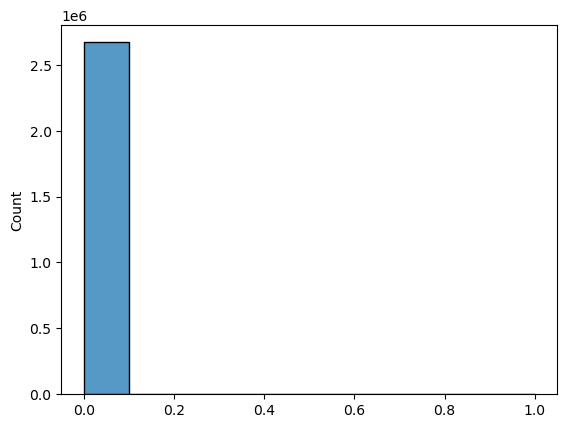

In [59]:
sns.histplot(y_pred_proba, bins=10)
plt.show()

In [60]:
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,days_to_trip,26.460795
1,age_at_trip,15.668167
2,age,14.755310
3,score_price_interaction,6.331080
4,vehclass_avg_price_per_seat,4.498736
5,channel_avg_price,4.327748
6,max_risk_score,4.267207
7,vehclass_id,3.036386
8,score_security_interaction,2.563635
9,days_from_creation_to_trip,2.130728


In [72]:
def lift_metric_plot(model, X_test, y_test):
    all_pred = pd.DataFrame()
    all_pred["prob"] = model.predict_proba(X_test)[:, 1]
    all_pred["true"] = y_test.values
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import accuracy_score

    y_true = all_pred["true"]
    recall = []
    precision = []
    score = []
    f_score = []

    aa = -np.sort(
        -all_pred["prob"].describe(percentiles=np.linspace(0, 1, 101))[4:105].values
    )
    for i in range(0, len(aa)):
        f = lambda x: 1 if x >= aa[i] else 0
        score.append(aa[i])
        y_pred = all_pred["prob"].map(f)
        g = recall_score(y_true, y_pred, average="binary")
        recall.append(g)
        p = precision_score(y_true, y_pred, average="binary")
        precision.append(p)
        t = f1_score(y_true, y_pred, average="binary")
        f_score.append(t)

    temp = pd.DataFrame()
    temp["score"] = score
    temp["recall"] = recall
    temp["precision"] = precision
    temp["top_percentile"] = np.round(list(np.linspace(0, 100, 101))).tolist()

    temp["lift"] = temp["recall"] / (temp["top_percentile"] / 100.0)
    temp["max_lift"] = 1 / (y_test.sum() / len(y_test))
    temp["relative_lift"] = temp["lift"] / temp["max_lift"]

    temp["percent"] = 100 * (y_test.sum() / len(y_test))
    plt.figure()
    plt.plot(temp[1:]["top_percentile"], temp[1:]["lift"])
    plt.xlabel("Percentile")
    plt.ylabel("LIFT")
    plt.scatter(
        1,
        temp[temp["top_percentile"] == 1]["lift"][1],
        marker="o",
        s=30,
        zorder=10,
        color="b",
    )
    plt.text(
        1,
        temp[temp["top_percentile"] == 1]["lift"][1],
        "      top 1 : {}".format(
            np.round(temp[temp["top_percentile"] == 1]["lift"][1], 3)
        ),
        fontsize=10,
    )
    plt.scatter(
        10,
        temp[temp["top_percentile"] == 10]["lift"][10],
        marker="o",
        s=30,
        zorder=10,
        color="b",
    )
    plt.text(
        10,
        temp[temp["top_percentile"] == 10]["lift"][10],
        "      top 10 : {}".format(
            np.round(temp[temp["top_percentile"] == 10]["lift"][10], 3)
        ),
        fontsize=10,
    )
    plt.title("Lift-chart")
    plt.figure()
    plt.plot(temp[1:]["top_percentile"], temp[1:]["relative_lift"])
    plt.xlabel("Percentile")
    plt.ylabel("Relative_lift")
    plt.scatter(
        1,
        temp[temp["top_percentile"] == 1]["relative_lift"][1],
        marker="o",
        s=30,
        zorder=10,
        color="b",
    )
    plt.text(
        1,
        temp[temp["top_percentile"] == 1]["relative_lift"][1],
        "      top 1 : {}".format(
            np.round(temp[temp["top_percentile"] == 1]["relative_lift"][1], 3)
        ),
        fontsize=10,
    )
    plt.scatter(
        10,
        temp[temp["top_percentile"] == 10]["relative_lift"][10],
        marker="o",
        s=30,
        zorder=10,
        color="b",
    )
    plt.text(
        10,
        temp[temp["top_percentile"] == 10]["relative_lift"][10],
        "      top 10 : {}".format(
            np.round(temp[temp["top_percentile"] == 10]["relative_lift"][10], 3)
        ),
        fontsize=10,
    )
    plt.title("Relative-lift-chart")
    plt.figure()
    plt.plot(temp[1:]["top_percentile"], temp[1:]["recall"])
    plt.xlabel("Percentile")
    plt.ylabel("GAIN")
    plt.scatter(
        10,
        temp[temp["top_percentile"] == 10]["recall"][10],
        marker="o",
        s=30,
        zorder=10,
        color="b",
    )
    plt.text(
        10,
        temp[temp["top_percentile"] == 10]["recall"][10],
        "      top 10 : {}".format(
            np.round(temp[temp["top_percentile"] == 10]["recall"][10], 3)
        ),
        fontsize=10,
    )
    plt.scatter(
        40,
        temp[temp["top_percentile"] == 40]["recall"][40],
        marker="o",
        s=30,
        zorder=10,
        color="b",
    )
    plt.text(
        40,
        temp[temp["top_percentile"] == 40]["recall"][40],
        "      top 40 : {}".format(
            np.round(temp[temp["top_percentile"] == 40]["recall"][40], 3)
        ),
        fontsize=10,
    )
    plt.title("Gain-chart")
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(
        fpr, tpr, color="darkorange", lw=1, label="ROC curve (area = %0.2f)" % roc_auc
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.show()
    print(temp[1:].head(10))
    return temp[1:]

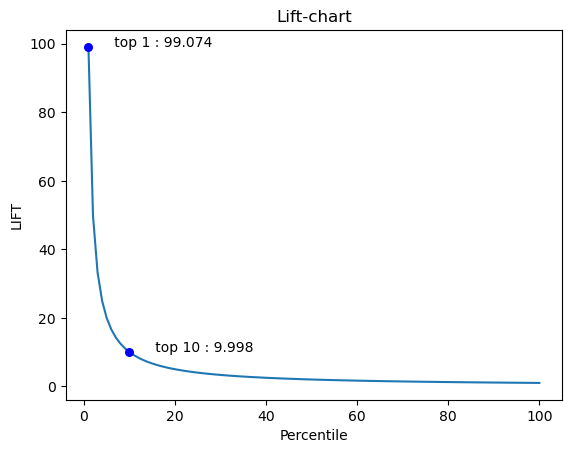

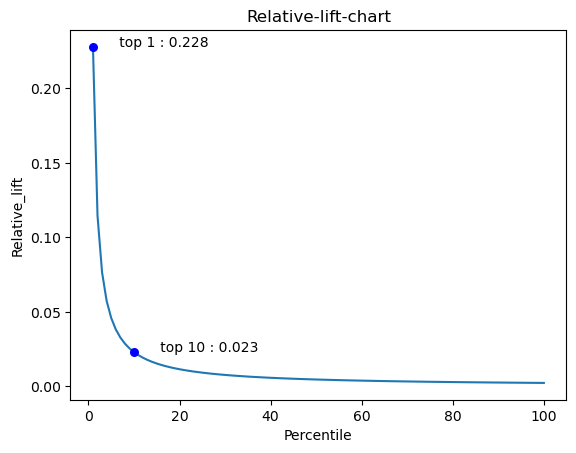

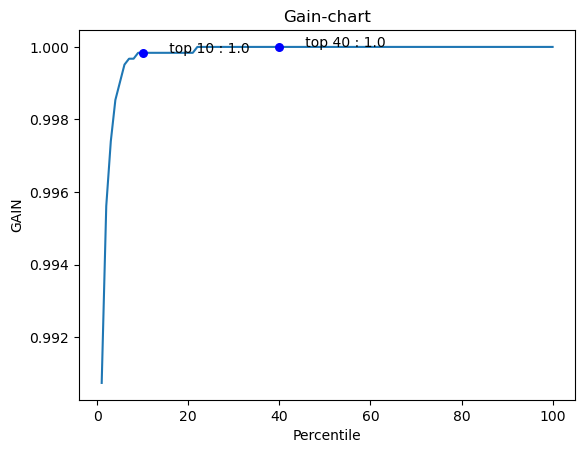

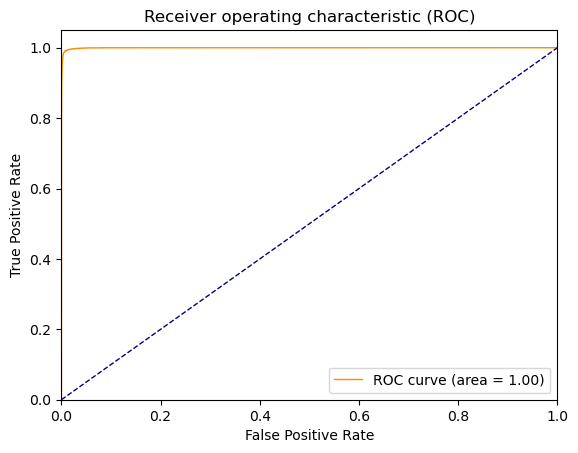

       score    recall  precision  top_percentile       lift    max_lift  \
1   0.000829  0.990739   0.227809             1.0  99.073924  434.895695   
2   0.000230  0.995613   0.114465             2.0  49.780666  434.895695   
3   0.000122  0.997400   0.076447             3.0  33.246683  434.895695   
4   0.000070  0.998538   0.057401             4.0  24.963444  434.895695   
5   0.000042  0.999025   0.045943             5.0  19.980504  434.895695   
6   0.000028  0.999513   0.038305             6.0  16.658543  434.895695   
7   0.000019  0.999675   0.032838             7.0  14.281072  434.895695   
8   0.000014  0.999675   0.028733             8.0  12.495938  434.895695   
9   0.000011  0.999838   0.025545             9.0  11.109306  434.895695   
10  0.000008  0.999838   0.022990            10.0   9.998375  434.895695   

    relative_lift  percent  
1        0.227811  0.22994  
2        0.114466  0.22994  
3        0.076447  0.22994  
4        0.057401  0.22994  
5        0.045943 

,score,recall,precision,top_percentile,lift,max_lift,relative_lift,percent
1,8.294484e-04,0.990739,0.227809,1.0,99.073924,434.895695,0.227811,0.22994
2,2.303617e-04,0.995613,0.114465,2.0,49.780666,434.895695,0.114466,0.22994
3,1.217636e-04,0.997400,0.076447,3.0,33.246683,434.895695,0.076447,0.22994
4,7.033434e-05,0.998538,0.057401,4.0,24.963444,434.895695,0.057401,0.22994
5,4.246010e-05,0.999025,0.045943,5.0,19.980504,434.895695,0.045943,0.22994
...,...,...,...,...,...,...,...,...
96,1.002033e-07,1.000000,0.002395,96.0,1.041667,434.895695,0.002395,0.22994
97,9.451158e-08,1.000000,0.002371,97.0,1.030928,434.895695,0.002371,0.22994
98,8.758997e-08,1.000000,0.002346,98.0,1.020408,434.895695,0.002346,0.22994
99,7.781903e-08,1.000000,0.002323,99.0,1.010101,434.895695,0.002323,0.22994


In [73]:
lift_metric_plot(clf, X_test, y_test)